In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import concat
%matplotlib inline

In [2]:
from pandas import read_csv
from datetime import datetime
# load data
dataset = read_csv('fei02_max.csv')

In [3]:
print(dataset.head(5))

      ����ʱ��  �й��������ֵ��kw��  ��  ��.1  һ��ڼ���  һ��ڼ���.1  weekday  ����  \
0  2019/10/10          2621.3316  10    10      283         41        3     4   
1  2019/10/11          2669.0172  10    11      284         41        4     4   
2  2019/10/12          2632.9704  10    12      285         41        5     4   
3  2019/10/13          1810.2156  10    13      286         41        6     4   
4  2019/10/14          2522.4576  10    14      287         42        0     4   

   �Ƿ��³�  �Ƿ���ĩ  �Ƿ񼾽ڳ�  �Ƿ񼾽�ĩ  �Ƿ���ĩ.1  ����״��  ����¶�  ����¶�.1  \
0       0       0      0      0         0      2.0    32.0      25.0   
1       0       0      0      0         0      1.0    33.0      25.0   
2       0       0      0      0         1      2.0    33.0      24.0   
3       0       0      0      0         1      9.0    31.0      23.0   
4       0       0      0      0         0      2.0    29.0      23.0   

   �����������  ҹ����������  
0         11.0          8.0  
1         11.0      

In [4]:
# manually specify column names
#dataset.drop('Unnamed: 0 ', axis=1, inplace=True)

In [5]:
print(dataset.head(5))

      ����ʱ��  �й��������ֵ��kw��  ��  ��.1  һ��ڼ���  һ��ڼ���.1  weekday  ����  \
0  2019/10/10          2621.3316  10    10      283         41        3     4   
1  2019/10/11          2669.0172  10    11      284         41        4     4   
2  2019/10/12          2632.9704  10    12      285         41        5     4   
3  2019/10/13          1810.2156  10    13      286         41        6     4   
4  2019/10/14          2522.4576  10    14      287         42        0     4   

   �Ƿ��³�  �Ƿ���ĩ  �Ƿ񼾽ڳ�  �Ƿ񼾽�ĩ  �Ƿ���ĩ.1  ����״��  ����¶�  ����¶�.1  \
0       0       0      0      0         0      2.0    32.0      25.0   
1       0       0      0      0         0      1.0    33.0      25.0   
2       0       0      0      0         1      2.0    33.0      24.0   
3       0       0      0      0         1      9.0    31.0      23.0   
4       0       0      0      0         0      2.0    29.0      23.0   

   �����������  ҹ����������  
0         11.0          8.0  
1         11.0      

In [6]:
dataset.columns = ['数据时间','有功功率最大值（kw）','月','天','一年第几天','一年第几周','weekday','季节','是否月初','是否月末','是否季节初','是否季节末','是否周末','天气状况','最高温度','最低温度','白天风力风向','夜晚风力风向']

In [7]:
dataset.drop('数据时间', axis=1, inplace=True)
# summarize first 5 rows
#print(dataset.head(5))
# save to file
dataset.to_csv('power.csv')

In [8]:
print(dataset)

     有功功率最大值（kw）   月   天  一年第几天  一年第几周  weekday  季节  是否月初  是否月末  是否季节初  是否季节末  \
0      2621.3316  10  10    283     41        3   4     0     0      0      0   
1      2669.0172  10  11    284     41        4   4     0     0      0      0   
2      2632.9704  10  12    285     41        5   4     0     0      0      0   
3      1810.2156  10  13    286     41        6   4     0     0      0      0   
4      2522.4576  10  14    287     42        0   4     0     0      0      0   
..           ...  ..  ..    ...    ...      ...  ..   ...   ...    ...    ...   
778          NaN  11  26    330     47        4   4     0     0      0      0   
779          NaN  11  27    331     47        5   4     0     0      0      0   
780          NaN  11  28    332     47        6   4     0     0      0      0   
781          NaN  11  29    333     48        0   4     0     0      0      0   
782          NaN  11  30    334     48        1   4     0     1      0      0   

     是否周末  天气状况   最高温度   最低

In [9]:
# prepare data for lstm
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('power.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
#print(reframed.head())
print(reframed.head)

<bound method NDFrame.head of      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1     0.488266   0.818182   0.300000   0.772603   0.769231   0.500000   
2     0.500543   0.818182   0.333333   0.775342   0.769231   0.666667   
3     0.491263   0.818182   0.366667   0.778082   0.769231   0.833333   
4     0.279437   0.818182   0.400000   0.780822   0.769231   1.000000   
5     0.462810   0.818182   0.433333   0.783562   0.788462   0.000000   
..         ...        ...        ...        ...        ...        ...   
687   0.685596   0.636364   0.833333   0.649315   0.634615   0.500000   
688   0.639233   0.636364   0.866667   0.652055   0.634615   0.666667   
689   0.435961   0.636364   0.900000   0.654795   0.634615   0.833333   
690   0.453448   0.636364   0.933333   0.657534   0.634615   1.000000   
691   0.667164   0.636364   0.966667   0.660274   0.653846   0.000000   

     var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1     1.000000   

In [10]:
#plt.plot(reframed)
#plt.show()

In [11]:
...
# split into train and test sets
values = reframed.values
n_train_hours = int(len(reframed)-91)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(600, 1, 17) (600,) (91, 1, 17) (91,)


Epoch 1/100
9/9 - 1s - loss: 0.2905 - val_loss: 0.3007 - 1s/epoch - 133ms/step
Epoch 2/100
9/9 - 0s - loss: 0.1775 - val_loss: 0.1477 - 26ms/epoch - 3ms/step
Epoch 3/100
9/9 - 0s - loss: 0.1520 - val_loss: 0.1024 - 23ms/epoch - 3ms/step
Epoch 4/100
9/9 - 0s - loss: 0.1553 - val_loss: 0.0958 - 23ms/epoch - 3ms/step
Epoch 5/100
9/9 - 0s - loss: 0.1503 - val_loss: 0.0979 - 26ms/epoch - 3ms/step
Epoch 6/100
9/9 - 0s - loss: 0.1419 - val_loss: 0.1030 - 23ms/epoch - 3ms/step
Epoch 7/100
9/9 - 0s - loss: 0.1355 - val_loss: 0.1025 - 28ms/epoch - 3ms/step
Epoch 8/100
9/9 - 0s - loss: 0.1301 - val_loss: 0.0967 - 24ms/epoch - 3ms/step
Epoch 9/100
9/9 - 0s - loss: 0.1255 - val_loss: 0.0930 - 25ms/epoch - 3ms/step
Epoch 10/100
9/9 - 0s - loss: 0.1215 - val_loss: 0.0918 - 23ms/epoch - 3ms/step
Epoch 11/100
9/9 - 0s - loss: 0.1176 - val_loss: 0.0918 - 24ms/epoch - 3ms/step
Epoch 12/100
9/9 - 0s - loss: 0.1139 - val_loss: 0.0920 - 25ms/epoch - 3ms/step
Epoch 13/100
9/9 - 0s - loss: 0.1108 - val_loss: 

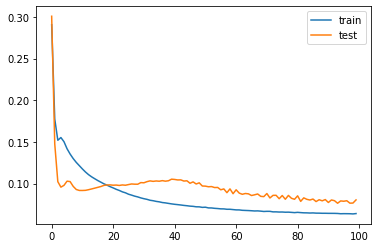

In [12]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [13]:
# make predictions
#trainPredict = model.predict(train_X)
#testPredict = model.predict(test_X)

In [14]:
...
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


In [15]:
yhat=DataFrame(yhat)
test_X=DataFrame(test_X)
print(yhat.shape,test_X.shape)

(91, 1) (91, 17)


In [16]:
test_X[0]=yhat
test_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.628331,0.454545,0.000000,0.413699,0.403846,0.166667,0.333333,1.0,0.0,0.0,0.0,0.0,0.625,0.785714,0.884615,0.875,0.875
1,0.602249,0.454545,0.033333,0.416438,0.403846,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.750,0.750000,0.884615,0.875,0.875
2,0.646013,0.454545,0.066667,0.419178,0.403846,0.500000,0.333333,0.0,0.0,0.0,0.0,0.0,0.625,0.892857,0.807692,0.875,0.875
3,0.558196,0.454545,0.100000,0.421918,0.403846,0.666667,0.333333,0.0,0.0,0.0,0.0,0.0,0.500,0.642857,0.769231,0.875,0.875
4,0.410057,0.454545,0.133333,0.424658,0.403846,0.833333,0.333333,0.0,0.0,0.0,0.0,1.0,0.125,0.785714,0.807692,0.875,0.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.679776,0.636364,0.833333,0.649315,0.634615,0.500000,0.666667,0.0,0.0,0.0,0.0,0.0,1.000,0.892857,0.923077,0.875,0.875
87,0.617164,0.636364,0.866667,0.652055,0.634615,0.666667,0.666667,0.0,0.0,0.0,0.0,0.0,1.000,0.892857,0.884615,0.875,0.875
88,0.527130,0.636364,0.900000,0.654795,0.634615,0.833333,0.666667,0.0,0.0,0.0,0.0,1.0,0.125,0.821429,0.884615,0.875,0.875
89,0.529271,0.636364,0.933333,0.657534,0.634615,1.000000,0.666667,0.0,0.0,0.0,0.0,1.0,1.000,0.785714,0.846154,0.875,0.875


In [17]:
inv_yhat = scaler.inverse_transform(test_X)
inv_yhat = inv_yhat[:,0]

In [18]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
test_X[0]=test_y
inv_y = scaler.inverse_transform(test_X)
inv_y = inv_y[:,0]

In [19]:
# calculate RMSE
from math import sqrt
#trainScore = sqrt(mean_squared_error(train_y[0], inv_yhat[0]))
#print('Train Score: %.3f RMSE' % (trainScore))
rmse2 = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test Score: %.3f' % rmse2)

Test Score: 398.122


In [20]:
inv_y

array([3058.767 , 3378.2148, 3056.7192, 1987.8998, 2208.2927, 3264.985 ,
       3381.0576, 3487.275 , 3435.0713, 3384.3228, 2450.01  , 2243.5698,
       2263.8083, 3395.592 , 3459.171 , 3491.2495, 3550.0073, 2785.4287,
       2568.6594, 3543.7805, 3060.4375, 3030.9912, 3019.9253, 3125.5703,
       2711.7996, 2543.823 , 3525.5027, 3412.975 , 3418.4358, 3525.0847,
       3414.8833, 2684.3633, 2384.652 , 3537.368 , 3535.4717, 3590.4653,
       3411.6797, 3268.4465, 2724.8706, 2410.6267, 3446.9321, 3211.09  ,
       3287.1643, 3362.649 , 3299.5723, 2573.7683, 2435.1533, 3202.2234,
       2992.4058, 3010.677 , 3093.2214, 3136.7058, 2698.9717, 2470.0735,
       3437.8057, 3403.74  , 3383.85  , 3374.145 , 3174.804 , 2677.5498,
       2428.833 , 2982.0955, 3133.0488, 3082.2073, 3003.123 , 3070.5173,
       2526.8003, 2343.5808, 3124.701 , 2854.7075, 2835.381 , 3092.5867,
       3010.4856, 2475.9534, 2210.9268, 3037.3127, 3135.368 , 3217.6968,
       3173.2944, 3208.2834, 2531.592 , 2321.0215, 

In [21]:
print(len(inv_y),len(inv_yhat))

91 91


In [22]:
inv_yhat

array([3165.3599, 3064.0547, 3234.037 , 2892.948 , 2317.5583, 2432.5603,
       3344.45  , 3456.1028, 3382.6648, 3408.6416, 3168.2578, 2664.0989,
       2546.0266, 2656.4963, 3529.997 , 3514.5552, 3472.8938, 3434.4128,
       3033.263 , 2826.4565, 3645.7375, 3177.0583, 3086.4326, 3018.6414,
       3008.5598, 2943.1084, 2791.1355, 3679.197 , 3513.0317, 3278.0688,
       3467.1992, 3276.656 , 2850.639 , 2601.0637, 3682.8367, 3497.4841,
       3491.1843, 3356.2156, 3205.2224, 2937.8145, 2648.3018, 3612.7249,
       3379.096 , 3372.4202, 3346.879 , 3152.712 , 2841.7012, 2674.0608,
       3368.8384, 3088.4836, 3082.5977, 3129.64  , 3110.4746, 2951.458 ,
       2756.5432, 3644.6616, 3568.9685, 3422.0369, 3325.434 , 3079.6501,
       2715.3633, 2596.6646, 3166.365 , 3220.5132, 3136.7778, 2982.9285,
       2999.6467, 2791.3098, 2639.94  , 3305.7278, 3005.072 , 2966.0027,
       3081.5452, 2938.6934, 2789.0312, 2533.009 , 3275.3396, 3335.5762,
       3338.5674, 3183.731 , 3171.0735, 2857.9424, 

In [23]:
import numpy as np
from sklearn import metrics
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))
print('MAPE:',mape(inv_y, inv_yhat))

MAPE: 0.1104844


In [24]:
from sklearn.metrics import r2_score
print('R2-score:',r2_score(inv_y, inv_yhat))

R2-score: 0.042929155568009025


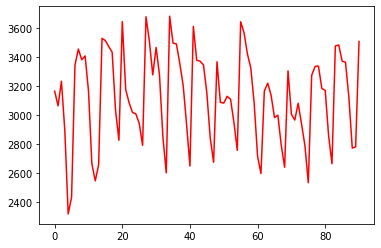

In [25]:
plt.plot(inv_yhat,'r')

In [26]:
import pandas as pd
inv_yhat=pd.DataFrame(data=inv_yhat)
inv_yhat.to_csv('inv_y.csv')
inv_yhat.to_csv('fei02_max_pre.csv')